# Activity 10.01: Building a model with Custom Layers and a Custom Loss Function

In [1]:
directory = "table-or-glass"

In [2]:
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import \
    ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, \
    BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model  


In [3]:
path = pathlib.Path(directory)

In [4]:
train_dir = path / 'training_set'
validation_dir = path / 'test_set'

In [5]:
train_table_dir = train_dir / 'table'
train_glass_dir = train_dir /'glass'
validation_table_dir = validation_dir / 'table'
validation_glass_dir = validation_dir / 'glass'

In [6]:
num_train_table = len([f for f in os.listdir(train_table_dir)if \
                       os.path.isfile(os.path.join\
                       (train_table_dir, f))])
num_train_glass = len([f for f in os.listdir(train_glass_dir)if \
                       os.path.isfile(os.path.join(train_glass_dir, f))])
num_validation_table = len([f for f in os.listdir\
                            (validation_table_dir)if
os.path.isfile(os.path.join(validation_table_dir, f))])
num_validation_glass = len([f for f in os.listdir\
                            (validation_glass_dir)if \
                            os.path.isfile\
                            (os.path.join\
                             (validation_glass_dir, f))])

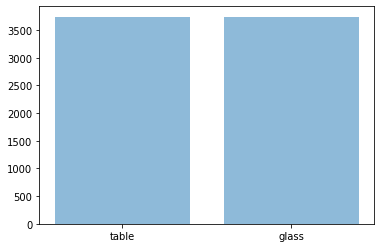

In [7]:
plt.bar(['table', 'glass'], \
        [num_train_table + num_validation_table, \
        num_train_glass + num_validation_glass], \
        align='center', 
        alpha=0.5)
plt.show()

In [8]:
total_train = len(os.listdir(train_table_dir)) + \
              len(os.listdir(validation_table_dir))
total_val = len(os.listdir(train_glass_dir)) + \
            len(os.listdir(validation_glass_dir))

In [9]:
from tensorflow.keras.preprocessing.image \
    import ImageDataGenerator

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [11]:
batch_size = 32
img_height = 100
img_width = 100

In [12]:
train_data_gen = train_image_generator.flow_from_directory\
                 (batch_size=batch_size, directory=train_dir, \
                  shuffle=True, \
                  target_size=(img_height, img_width), \
                  class_mode='binary')

Found 5236 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory\
               (batch_size=batch_size, directory=validation_dir,\
                target_size=(img_height, img_width), \
                class_mode='binary')

Found 2247 images belonging to 2 classes.


In [14]:
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [15]:
def relu_batchnorm_layer(input):
    return BatchNormalization()(ReLU()(input))

In [16]:
def residual_block(input, downsample: bool, filters: int, kernel_size: int = 3):
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        strides= (1 if not downsample else 2), 
                        padding="same")(input)
    int_output = relu_batchnorm_layer(int_output)
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        padding="same")(int_output)

    if downsample:
        int_output2 = Conv2D(filters=filters, kernel_size=1, strides=2,
                             padding="same")(input)
        output = Add()([int_output2, int_output]) 
    else:
        output = Add()([input, int_output])

    output = relu_batchnorm_layer(output)
    return output

In [17]:
inputs = Input(shape=(100, 100, 3))
num_filters = 32
    
t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3,
           strides=1,
           filters=32,
           padding="same")(t)
t = relu_batchnorm_layer(t)
    
num_blocks_list = [1, 3, 5, 6, 1]
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range(num_blocks):
        t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
    num_filters *= 2
    
t = AveragePooling2D(4)(t)
t = Flatten()(t)
outputs = Dense(1, activation='sigmoid')(t)
    
model = Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 100, 100, 32) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
model.compile(optimizer='adam',\
              loss=custom_loss_function,\
              metrics=['accuracy'])

In [20]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
116/116 [==============================] - 747s 6s/step - loss: 0.2266 - accuracy: 0.7170 - val_loss: 0.3582 - val_accuracy: 0.5251
Epoch 2/5
116/116 [==============================] - 669s 6s/step - loss: 0.1059 - accuracy: 0.8584
Epoch 3/5
116/116 [==============================] - 712s 6s/step - loss: 0.0855 - accuracy: 0.8887
Epoch 4/5
116/116 [==============================] - 779s 7s/step - loss: 0.0826 - accuracy: 0.8871
Epoch 5/5
116/116 [==============================] - 704s 6s/step - loss: 0.0741 - accuracy: 0.9014


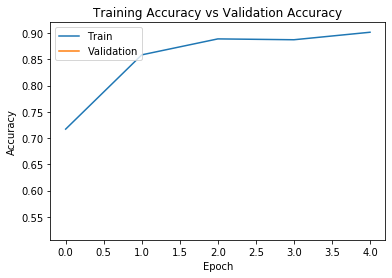

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

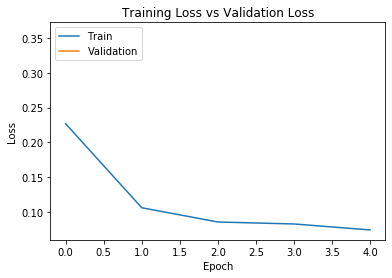

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()